# Integrated CA ML for Business and Data Visualisation

In [21]:
#!pip install jupyter_dash
#!pip install dash

In [22]:
#General
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output


# Time Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Text Analytics
import sklearn.feature_extraction.text as sk_txt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [23]:
df = pd.read_csv('FACEBOOK_REVIEWS.csv')

# Data Pre-Processing

In [24]:
df.head()

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,0,baecdfaa-fdcf-4ec2-8795-f9e1d0885c3a,167801889669597203549,Om******hy,bad app,1,0,318.0.0.39.154,2021-05-19 20:00:27
1,1,12e913d6-105e-4f0c-bb22-4f6a0561cb18,318460545610239421517,Sa****************ol,Really really annoying app ... like if its not...,1,0,317.0.0.51.119,2021-05-19 20:00:29
2,2,7db12237-0f42-4ef7-873b-99495d575331,530587565711923101092,Ca*********04,Cunsurinimo,1,0,293.0.0.43.120,2021-05-19 20:00:29
3,3,6d48f3e8-54c4-417a-83c9-6b198ef7c516,413352731163292273792,Ar**************07,Bad experience,1,0,318.0.0.39.154,2021-05-19 20:00:30
4,4,c4430a84-d74b-4e24-8ed6-1e28110a355b,972610065867074567951,Ab***********kh,Totally pathetic experience too many ads and b...,1,0,308.0.0.42.118,2021-05-19 20:00:30


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2994736 entries, 0 to 2994735
Data columns (total 9 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   Unnamed: 0          int64 
 1   review_id           object
 2   pseudo_author_id    object
 3   author_name         object
 4   review_text         object
 5   review_rating       int64 
 6   review_likes        int64 
 7   author_app_version  object
 8   review_timestamp    object
dtypes: int64(3), object(6)
memory usage: 205.6+ MB


In [26]:
df.columns

Index(['Unnamed: 0', 'review_id', 'pseudo_author_id', 'author_name',
       'review_text', 'review_rating', 'review_likes', 'author_app_version',
       'review_timestamp'],
      dtype='object')

In [27]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [28]:
df['review_timestamp'] = pd.to_datetime(df['review_timestamp'])

In [29]:
df['review_timestamp'].min(), df['review_timestamp'].max()

(Timestamp('2021-05-19 20:00:27'), Timestamp('2023-11-13 23:23:21'))

In [30]:
df.isna().sum()

review_id                  0
pseudo_author_id           0
author_name                0
review_text              450
review_rating              0
review_likes               0
author_app_version    652863
review_timestamp           0
dtype: int64

In [31]:
df.dropna(inplace=True)
df.isna().sum()

review_id             0
pseudo_author_id      0
author_name           0
review_text           0
review_rating         0
review_likes          0
author_app_version    0
review_timestamp      0
dtype: int64

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2341493 entries, 0 to 2994735
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   review_id           object        
 1   pseudo_author_id    object        
 2   author_name         object        
 3   review_text         object        
 4   review_rating       int64         
 5   review_likes        int64         
 6   author_app_version  object        
 7   review_timestamp    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 160.8+ MB


## Data Visualisation Part 1

In [33]:
df.describe()

,review_rating,review_likes,review_timestamp
count,2.341493e+06,2.341493e+06,2341493
mean,2.937783e+00,3.510604e+00,2022-04-28 22:59:44.241313536
min,1.000000e+00,0.000000e+00,2021-05-19 20:00:27
25%,1.000000e+00,0.000000e+00,2021-07-16 10:22:16
50%,3.000000e+00,0.000000e+00,2022-02-25 19:34:50
75%,5.000000e+00,0.000000e+00,2022-12-23 00:22:33
max,5.000000e+00,8.418000e+04,2023-11-13 23:23:21
std,1.882540e+00,2.209054e+02,NaN


#### Histplot with the count of review ratings 

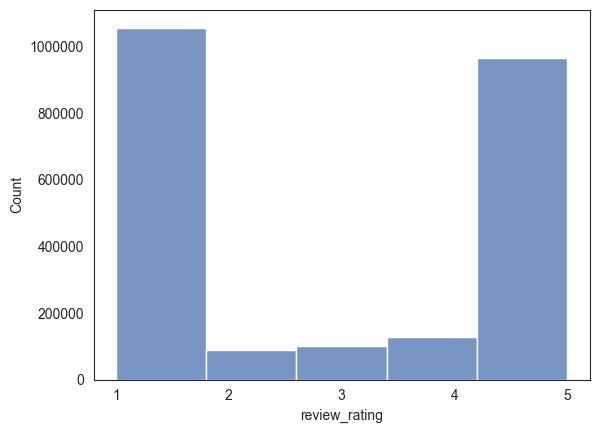

In [34]:
sns.set_style("white") 
sns.set_palette('deep') 
bins = list(set(df['review_rating'].unique()))
ax = sns.histplot(df['review_rating'], bins=5, kde=False)
plt.ticklabel_format(style='plain', axis='y')
ax.set_xticks(bins)
plt.show()

#### Bar Chart with count of review ratings per year

In [35]:
df['Year'] = df['review_timestamp'].dt.year
year = df.groupby(['Year','review_rating']).review_rating.value_counts().reset_index()

In [36]:
fig = px.bar(year,
            x= 'Year',
            y= 'count',
            color = 'review_rating',
            hover_data = {
                'count': ':,.0f'
            })
fig.show()

#### Scatterplot and Trendline with count of review likes by review rating

In [37]:
likes = df.groupby('review_rating')['review_likes'].sum().reset_index()

In [38]:
fig = px.scatter(likes,
         x='review_rating',
         y='review_likes',
         hover_data={
            'review_rating': ':,.f'
         },
         labels={
            'review_rating': 'Rating'
         },
         trendline='ols')
fig.show()

### Feature Creation for Time Series Analysis

In [39]:
df['year'] = df['review_timestamp'].dt.year
df_2022_23 = df[(df['year'] == 2022) | (df['year'] == 2023)]


In [40]:
df_2022_23['week'] = df_2022_23['review_timestamp'].dt.isocalendar().week


In [41]:
df_2022_23['date']= df_2022_23['review_timestamp'].dt.date
df_2022_23['date'] = pd.to_datetime(df_2022_23['date'])
df_2022_23['date'] 

1299162   2022-01-01
1299163   2022-01-01
1299165   2022-01-01
1299168   2022-01-01
1299169   2022-01-01
             ...    
2994731   2023-11-13
2994732   2023-11-13
2994733   2023-11-13
2994734   2023-11-13
2994735   2023-11-13
Name: date, Length: 1298407, dtype: datetime64[ns]

In [42]:
unique_reviews_per_day = df_2022_23.groupby(['date'])['review_id'].nunique().reset_index(name='unique_reviews')
unique_reviews_per_day

,date,unique_reviews
0,2022-01-01,2029
1,2022-01-02,2208
2,2022-01-03,2013
3,2022-01-04,2081
4,2022-01-05,2234
...,...,...
677,2023-11-09,3204
678,2023-11-10,2501
679,2023-11-11,2146
680,2023-11-12,2207


<Axes: xlabel='date'>

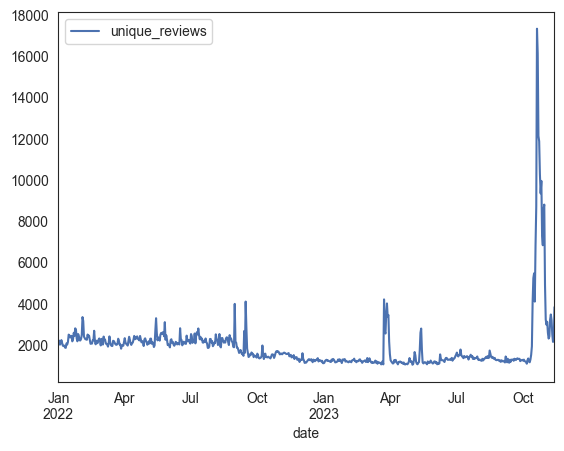

In [43]:
unique_reviews_per_day.plot(x="date", y="unique_reviews")

In [44]:
adfuller(unique_reviews_per_day['unique_reviews'])

(-4.5579996063746,
 0.00015426138921788662,
 12,
 669,
 {'1%': -3.4401625092086467,
  '5%': -2.865869922737958,
  '10%': -2.5690758278089465},
 10148.473746315094)

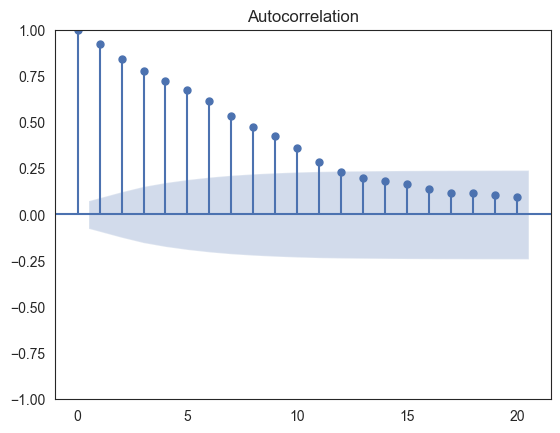

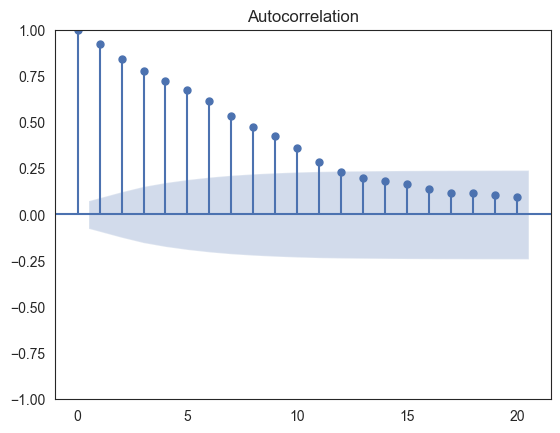

In [45]:
plot_acf(unique_reviews_per_day["unique_reviews"].dropna(),lags=20)
# q = has a significant coefficient until lag 10

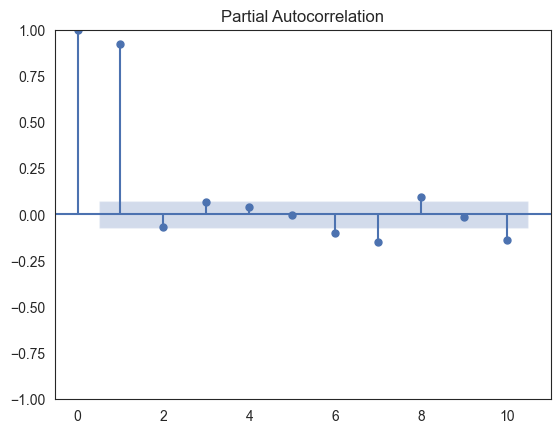

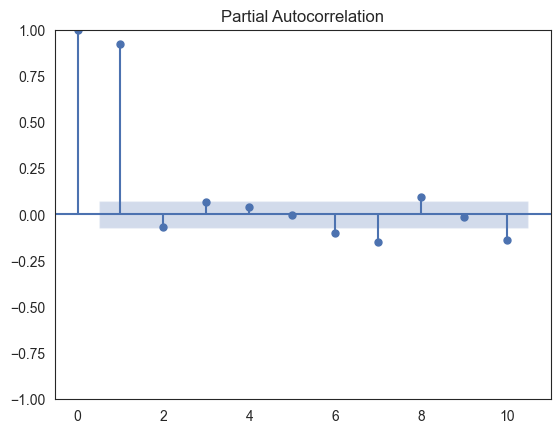

In [46]:
plot_pacf(unique_reviews_per_day["unique_reviews"].dropna(),lags=10)
# p = 1 has a significant correlation with the previous value

In [47]:
from statsmodels.tsa.arima.model import ARIMA
aicVals = []
for p in range(0,1):
    p = 1
    for d in range(5):
        for q in range(1,5):
            print(p, d, q)
            
            try:
                aic = ARIMA(unique_reviews_per_day["unique_reviews"], order=(p, d, q)).fit().aic
                aicVals.append([aic, p, d, q])
            except np.linalg.LinAlgError:
                print(f"Unable to fit model for order=({p}, {d}, {q})")

1 0 5
1 0 6
1 0 7
1 0 8
1 0 9
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 2 5
1 2 6
1 2 7
1 2 8
1 2 9
1 3 5
1 3 6
1 3 7
1 3 8
1 3 9
1 4 5
1 4 6
1 4 7
1 4 8
1 4 9


In [48]:
model = ARIMA(unique_reviews_per_day["unique_reviews"], order=(1, 0, 5)).fit()

In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unique_reviews   No. Observations:                  682
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -5246.367
Date:                Sat, 25 Nov 2023   AIC                          10508.734
Time:                        22:38:30   BIC                          10544.934
Sample:                             0   HQIC                         10522.744
                                - 682                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1903.8226    485.010      3.925      0.000     953.221    2854.424
ar.L1          0.9198      0.010     88.201      0.000       0.899       0.940
ma.L1          0.0601      0.026      2.315      0.021       0.009       0.111
ma.L2         -0.0547      0.017     -3.272      0.001      -0.088      -0.022
ma.L3         -0.0274      0.028     -0.967      0.334      -0.083       0.028
ma.L4          0.0026      0.019      0.140      0.889      -0.034       0.040
ma.L5          0.0642      0.025      2.550      0.011       0.015       0.114
sigma2      2.887e+05   3861.931     74.768      0.000    2.81e+05    2.96e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):            521341.78
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):              12.33   Skew:                             7.91
Prob(H) (two-sided):                  0.00   Kurtosis:                       137.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
model = ARIMA(unique_reviews_per_day["unique_reviews"], order=(1, 0, 2)).fit()

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unique_reviews   No. Observations:                  682
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -5248.061
Date:                Sat, 25 Nov 2023   AIC                          10506.122
Time:                        22:38:31   BIC                          10528.747
Sample:                             0   HQIC                         10514.878
                                - 682                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1903.8227    469.494      4.055      0.000     983.632    2824.013
ar.L1          0.9218      0.010     89.634      0.000       0.902       0.942
ma.L1          0.0774      0.023      3.386      0.001       0.033       0.122
ma.L2         -0.0635      0.018     -3.607      0.000      -0.098      -0.029
sigma2      2.853e+05   3424.831     83.295      0.000    2.79e+05    2.92e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            546961.68
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              12.41   Skew:                             8.03
Prob(H) (two-sided):                  0.00   Kurtosis:                       140.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
pred_time = 1 # predict 1 time step into the future
result = model.predict(start=unique_reviews_per_day["unique_reviews"].shape[0]-10, end=unique_reviews_per_day["unique_reviews"].shape[0] + pred_time).reset_index(drop=True)

In [53]:
result

0     3057.995560
1     2476.073399
2     2293.961293
3     2388.092855
4     3184.235493
5     3323.214417
6     3074.562394
7     2417.527762
8     2142.499447
9     2205.541698
10    3805.022703
11    3552.989408
Name: predicted_mean, dtype: float64

In [54]:
predictions = result.iloc[:-1]
predictions

0     3057.995560
1     2476.073399
2     2293.961293
3     2388.092855
4     3184.235493
5     3323.214417
6     3074.562394
7     2417.527762
8     2142.499447
9     2205.541698
10    3805.022703
Name: predicted_mean, dtype: float64

In [55]:
actual_last10 = unique_reviews_per_day.tail(11).reset_index(drop=True)
actual_last10

,date,unique_reviews
0,2023-11-03,3123
1,2023-11-04,2577
2,2023-11-05,2308
3,2023-11-06,2408
4,2023-11-07,3230
5,2023-11-08,3477
6,2023-11-09,3204
7,2023-11-10,2501
8,2023-11-11,2146
9,2023-11-12,2207


In [57]:
from math import sqrt
rmse = sqrt(mean_squared_error(actual_last10['unique_reviews'], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 77.063


In [58]:
from sklearn.metrics import r2_score
# Calculate R^2 score
r2 = r2_score(actual_last10['unique_reviews'], predictions)
print('Test R^2: %.3f' % r2)

Test R^2: 0.980


In [59]:
unique_reviews_per_day

,date,unique_reviews
0,2022-01-01,2029
1,2022-01-02,2208
2,2022-01-03,2013
3,2022-01-04,2081
4,2022-01-05,2234
...,...,...
677,2023-11-09,3204
678,2023-11-10,2501
679,2023-11-11,2146
680,2023-11-12,2207


In [60]:
# Split into train and test sets
size = int(len(unique_reviews_per_day["unique_reviews"]) * 0.7)
train, test = unique_reviews_per_day["unique_reviews"][0:size], unique_reviews_per_day["unique_reviews"][size:len(unique_reviews_per_day)]

In [61]:
train.shape, test.shape

((477,), (205,))

In [62]:
model = ARIMA(train, order=(1, 0, 2)).fit()

In [63]:
# Make predictions
predict = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predict))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import r2_score
# Calculate R^2 score
r2 = r2_score(test, predict)
print('Test R^2: %.3f' % r2)

Test RMSE: 2394.323
Test R^2: -0.001


#### Bad Result fitting the model to the raw training data. data preperation is required to solve this.

In [64]:
Q1 = unique_reviews_per_day['unique_reviews'].quantile(0.25)
Q3 = unique_reviews_per_day['unique_reviews'].quantile(0.75)
IQR = Q3 - Q1

# Create a new DataFrame excluding outliers
df_clean = unique_reviews_per_day[~((unique_reviews_per_day['unique_reviews'] < (Q1 - 1.5 * IQR)) |(unique_reviews_per_day['unique_reviews'] > (Q3 + 1.5 * IQR)))]
df_clean

,date,unique_reviews
0,2022-01-01,2029
1,2022-01-02,2208
2,2022-01-03,2013
3,2022-01-04,2081
4,2022-01-05,2234
...,...,...
676,2023-11-08,3477
677,2023-11-09,3204
678,2023-11-10,2501
679,2023-11-11,2146


<Axes: xlabel='date'>

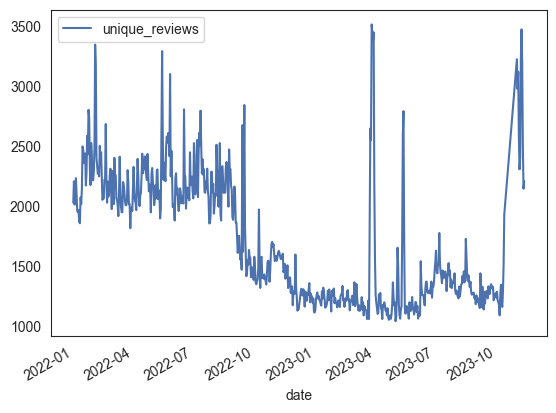

In [65]:
df_clean.plot(x="date", y="unique_reviews")

In [66]:
adfuller(df_clean['unique_reviews'])
# p-value < 0.05, so we can reject the null hypothesis that the data is not stationary

(-2.992460945100666,
 0.03560447657612172,
 5,
 653,
 {'1%': -3.4404038931945276,
  '5%': -2.865976260062519,
  '10%': -2.5691324834372633},
 8674.567330975071)

In [68]:
# Split into train and test sets
train_size = int(len(df_clean["unique_reviews"]) * 0.7)
train, test = df_clean["unique_reviews"][0:train_size], df_clean["unique_reviews"][train_size:len(df_clean)]

In [69]:
train.shape, test.shape

((461,), (198,))

In [70]:
# Fit the model
model = ARIMA(train, order=(2, 1, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unique_reviews   No. Observations:                  461
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3129.534
Date:                Sat, 25 Nov 2023   AIC                           6267.068
Time:                        22:43:45   BIC                           6283.592
Sample:                             0   HQIC                          6273.575
                                - 461                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5928      0.030     19.853      0.000       0.534       0.651
ar.L2          0.1172      0.026      4.518      0.000       0.066       0.168
ma.L1         -0.9553      0.021    -44.567      0.000      -0.997      -0.913
sigma2       4.74e+04   1370.824     34.576      0.000    4.47e+04    5.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              2900.51
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             2.00
Prob(H) (two-sided):                  0.89   Kurtosis:                        14.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
predictions = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

mae = mean_absolute_error(test, predictions)
print('Test MAE: %.2f'% mae)

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test MAE: 254.83
Test RMSE: 422.032


In [72]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test, predictions)
print('Test MAPE: %.2f' % mape)

Test MAPE: 16.46


## Text Analytics

In [73]:
df

,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,Year,year
0,baecdfaa-fdcf-4ec2-8795-f9e1d0885c3a,167801889669597203549,Om******hy,bad app,1,0,318.0.0.39.154,2021-05-19 20:00:27,2021,2021
1,12e913d6-105e-4f0c-bb22-4f6a0561cb18,318460545610239421517,Sa****************ol,Really really annoying app ... like if its not...,1,0,317.0.0.51.119,2021-05-19 20:00:29,2021,2021
2,7db12237-0f42-4ef7-873b-99495d575331,530587565711923101092,Ca*********04,Cunsurinimo,1,0,293.0.0.43.120,2021-05-19 20:00:29,2021,2021
3,6d48f3e8-54c4-417a-83c9-6b198ef7c516,413352731163292273792,Ar**************07,Bad experience,1,0,318.0.0.39.154,2021-05-19 20:00:30,2021,2021
4,c4430a84-d74b-4e24-8ed6-1e28110a355b,972610065867074567951,Ab***********kh,Totally pathetic experience too many ads and b...,1,0,308.0.0.42.118,2021-05-19 20:00:30,2021,2021
...,...,...,...,...,...,...,...,...,...,...
2994731,f01698fa-5056-4199-b88f-d294050062cb,272225995443346295413,Ji**********ur,eed Red; Red raCCC !duxiixiuz En do,1,0,440.0.0.31.105,2023-11-13 23:20:59,2023,2023
2994732,796fa280-6530-49dc-bc7d-f93ae086b31d,147368069644520083993,A Google user,Not been working all day and no update availab...,1,0,440.0.0.31.105,2023-11-13 23:21:20,2023,2023
2994733,b31e8e70-4e3b-419b-aa2f-a8a3f5a0bd05,257906640422320735099,Wa***********em,Absolute bias towards Israel,1,0,436.0.0.35.101,2023-11-13 23:21:26,2023,2023
2994734,a229e971-5a99-47c7-bf07-48ca9c8ed491,180604354313420497079,Na********ed,لا حريه ف التعبر,1,0,438.0.0.33.118,2023-11-13 23:21:31,2023,2023


In [74]:
#pip install langdetect
#pip install nltk

In [75]:
df = df[df['year'] == 2023]

In [76]:
df['review_text'] = df['review_text'].dropna()

In [77]:
df['review_text'] = df['review_text'].astype(str)

In [78]:
df['review_text']

2264704                                   Wow it is nice app
2264708                                            Fahad❤️❤️
2264709                                                 Nice
2264710                                       Tbeml 5 EDT no
2264711    Lecturer in odia aditya jr. and degree college...
                                 ...                        
2994731                  eed Red; Red raCCC !duxiixiuz En do
2994732    Not been working all day and no update availab...
2994733                         Absolute bias towards Israel
2994734                                     لا حريه ف التعبر
2994735                         Absolute bias towards Israel
Name: review_text, Length: 574437, dtype: object

In [83]:
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer
import string



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johannes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johannes/nltk_data...


In [84]:
# Text preprocessing
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in df['review_text']]
doc_clean

[['wow', 'nice', 'app'],
 ['fahad❤️❤️'],
 ['nice'],
 ['tbeml', '5', 'edt'],
 ['lecturer',
  'odia',
  'aditya',
  'jr',
  'degree',
  'college',
  'ichchapuram',
  '0k'],
 ['good'],
 ['want', 'grow', 'account'],
 [],
 ['app', 'crash', 'problame'],
 ['created',
  'different',
  'account',
  'people',
  'life',
  'want',
  'comment',
  'stuff',
  'said',
  'meet',
  'community',
  'standard',
  'whatever',
  'looking',
  'house',
  'rent',
  'way',
  'facebooks',
  'going',
  'im',
  'going',
  'ever',
  'facebook',
  'turned',
  'garbage'],
 ['pravinthakor'],
 ['please',
  'facebook😥my',
  'account',
  'hacked',
  'someone',
  'hacked',
  'facebook',
  'account',
  'changed',
  'account',
  'numberemail',
  'password',
  'data',
  'date',
  'birth',
  'please',
  'help',
  'really',
  'need',
  'help',
  'please'],
 ['😄😗🤑🤑'],
 ['s'],
 ['great'],
 ['good'],
 ['ih'],
 ['best'],
 ['ok'],
 ['facbook', 'good', 'place', 'vews', 'com'],
 ['agli', 'app', '👎👎👎'],
 ['video',
  'stopped',
  'playi

In [85]:
# Vectorization
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
data_vectorized = vectorizer.fit_transform(df['review_text'])


In [86]:
# LDA Model
lda_model = LatentDirichletAllocation(n_components=10, random_state=0)
lda_model.fit(data_vectorized)

# Visualization
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel